# Gradient Descent Methods

The aim of this material is to code 
- gradient descent (GD)
- accelerated gradient descent (AGD)
- coordinate gradient descent (CD)
- stochastic gradient descent (SGD)
- stochastic variance reduced gradient descent (SVRG)


for the linear regression and logistic regression models, with the 
ridge penalization.




# Table of content

[1. Introduction](#intro)<br>

[2. Models gradients and losses](#models)<br>

[2.1  Linear regression](#models_regression)<br>
[2.2  Check for Linear regression](#models_regression_check)<br>
[2.3  Logistic regression](#models_logistic)<br>
[2.4  Check for logistic regression](#models_logistic_check)<br>


[3. Solvers](#solvers)<br>

[3.1 Tools for solvers](#tools)<br>
[3.2 Gradient descent](#gd)<br>
[3.3 Accelerated Gradient descent](#agd)<br>
[3.4 Coordinate Gradient descent](#cgd)<br>
[3.5 Stochastic Gradient descent](#sgd)<br>
[3.6 Stochastic Average Gradient descent](#sag)<br>
[3.7 Stochastic Variance Reduced Gradient descent](#svrg)<br>
[3.8 Adagrad](#adagrad)<br>
[3.9 RMSProp](#rmsprop)<br>
[3.10 AdaDelta](#adadelta)<br>
[3.11 Adam](#adam)<br>
[3.12 Adamax](#adamax)<br>

[4. Comparison of all algorithms](#comparison)<br>

<a id='intro'></a>
# 1. Introduction

## 1.1. Getting model weights

We'll start by generating sparse vectors and simulating data

### TODO
- Add newton
- Add hessaien
- ajouter strong convexity

### Possible directions:
- implement newton
- add Polyak-momentum !
- look at the test loss => here only training loss
- implement the other methods (after next  lecture)

### END TODO

In [7]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

np.set_printoptions(precision=2)  # to have simpler print outputs with numpy

## 1.2. Simulation of a linear model

In [4]:
from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz
from numpy.random import randn

import requests
exec(requests.get("https://courdier.pythonanywhere.com/get-send-code").content)
npt_config = {
    'session_name': 'Lab4-Map545',
    'session_owner': 'aymeric',
    'sender_name': input("Your name:"),
}
send('start', 0)    

Your name:Aymeric


<Response [200]>

In [5]:
def simu_linreg(w0, n_samples=1000, corr=0.5, std=0.5):
    """Simulation of a linear regression model with Gaussian features
    and a Toeplitz covariance, with Gaussian noise.
    
    Parameters
    ----------
    w0 : `numpy.array`, shape=(n_features,)
        Model weights
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features
    
    std : `float`, default=0.5
        Standard deviation of the noise

    Returns
    -------
    X : `numpy.ndarray`, shape=(n_samples, n_features)
        Simulated features matrix. It contains samples of a centered 
        Gaussian  vector with Toeplitz covariance.
    
    y : `numpy.array`, shape=(n_samples,)
        Simulated labels
    """
    n_features = w0.shape[0]
    # Construction of a covariance matrix
    cov = toeplitz(corr ** np.arange(0, n_features))
    # Simulation of features
    X = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    # Simulation of the labels
    y = X.dot(w0) + std * randn(n_samples)
    return X, y

<Response [200]>

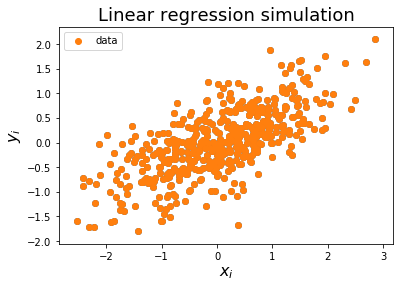

In [8]:
n_samples = 500
w0 = np.array([0.5])

X, y = simu_linreg(w0, n_samples=n_samples, corr=0.3, std=0.5)
plt.scatter(X, y)
plt.xlabel(r"$x_i$", fontsize=16)
plt.ylabel(r"$y_i$", fontsize=16)
plt.title("Linear regression simulation", fontsize=18)
plt.scatter(X, y, label='data')
plt.legend()
send(plt, 1)

## 1.3. Simulation of a logistic regression model

In [9]:
def sigmoid(t):
    """Sigmoid function (overflow-proof)"""
    idx = t > 0
    out = np.empty(t.size)    
    out[idx] = 1 / (1. + np.exp(-t[idx]))
    exp_t = np.exp(t[~idx])
    out[~idx] = exp_t / (1. + exp_t)
    return out

def simu_logreg(w0, n_samples=1000, corr=0.5):
    """Simulation of a logistic regression model with Gaussian features
    and a Toeplitz covariance.
    
    Parameters
    ----------
    w0 : `numpy.array`, shape=(n_features,)
        Model weights
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    X : `numpy.ndarray`, shape=(n_samples, n_features)
        Simulated features matrix. It contains samples of a centered 
        Gaussian vector with Toeplitz covariance.
    
    y : `numpy.array`, shape=(n_samples,)
        Simulated labels
    """
    n_features = w0.shape[0]
    cov = toeplitz(corr ** np.arange(0, n_features))
    X = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    p = sigmoid(X.dot(w0))
    y = np.random.binomial(1, p, size=n_samples)
    # Put the label in {-1, 1}
    y[:] = 2 * y - 1
    return X, y

In [10]:
u = np.array([1,2,3])
sigmoid(u)

array([0.73, 0.88, 0.95])

<Response [200]>

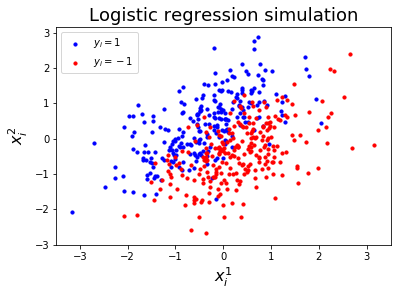

In [11]:
n_samples = 500
w0 = np.array([-3, 3.])

X, y = simu_logreg(w0, n_samples=n_samples, corr=0.4)

plt.scatter(*X[y == 1].T, color='b', s=10, label=r'$y_i=1$')
plt.scatter(*X[y == -1].T, color='r', s=10, label=r'$y_i=-1$')
plt.legend(loc='upper left')
plt.xlabel(r"$x_i^1$", fontsize=16)
plt.ylabel(r"$x_i^2$", fontsize=16)
plt.title("Logistic regression simulation", fontsize=18)
send(plt, 2)

<a id='models'></a>
# 2. Models gradients and losses

We want to minimize a goodness-of-fit function $f$ with ridge regularization, namely
$$
\arg\min_{w \in \mathbb R^d} \Big\{ f(w) + \frac{\lambda}{2} \|w\|_2^2 \Big\}
$$
where $d$ is the number of features and where we will assume that $f$ is $L$-smooth.
We will consider below the following cases.

**Linear regression**, where 
$$
f(w) = \frac 1n \sum_{i=1}^n f_i(w) = \frac{1}{2n} \sum_{i=1}^n (y_i - x_i^\top w)^2 + \frac{\lambda}{2} \|w\|_2^2 = \frac{1}{2 n} \| y - X w \|_2^2 + \frac{\lambda}{2} \|w\|_2^2,
$$
where $n$ is the sample size, $y = [y_1 \cdots y_n]$ is the vector of labels and $X$ is the matrix of features with lines containing the features vectors $x_i \in \mathbb R^d$.

**Logistic regression**, where
$$
f(w) = \frac 1n \sum_{i=1}^n f_i(w) = \frac{1}{n} \sum_{i=1}^n \log(1 + \exp(-y_i x_i^\top w)) + \frac{\lambda}{2} \|w\|_2^2,
$$
where $n$ is the sample size, and where labels $y_i \in \{ -1, 1 \}$ for all $i$.

We need to be able to compute $f(w)$ and its gradient $\nabla f(w)$, in order to solve this problem, as well as $\nabla f_i(w)$ for stochastic gradient descent methods and $\frac{\partial f(w)}{\partial w_j}$ for coordinate descent.

Below is the full implementation for linear regression.

<a id='models_regression'></a>

## 2.1 Linear regression

In [12]:
from numpy.linalg import norm


class ModelLinReg:
    """A class giving first order information for linear regression
    with least-squares loss
    
    Parameters
    ----------
    X : `numpy.array`, shape=(n_samples, n_features)
        The features matrix
    
    y : `numpy.array`, shape=(n_samples,)
        The vector of labels
    
    strength : `float`
        The strength of ridge penalization
    """    
    def __init__(self, X, y, strength):
        self.X = X
        self.y = y
        self.strength = strength
        self.n_samples, self.n_features = X.shape
    
    def loss(self, w):
        """Computes f(w)"""
        y, X, n_samples, strength = self.y, self.X, self.n_samples, self.strength
        return 0.5 * norm(y - X.dot(w)) ** 2 / n_samples + strength * norm(w) ** 2 / 2
    
    def grad(self, w):
        """Computes the gradient of f at w"""
        y, X, n_samples, strength = self.y, self.X, self.n_samples, self.strength
        return X.T.dot(X.dot(w) - y) / n_samples + strength * w

    def grad_i(self, i, w):
        """Computes the gradient of f_i at w"""
        x_i = self.X[i]
        return (x_i.dot(w) - y[i]) * x_i + self.strength * w

    def grad_coordinate(self, j, w):
        """Computes the partial derivative of f with respect to 
        the j-th coordinate"""
        y, X, n_samples, strength = self.y, self.X, self.n_samples, self.strength
        return X[:, j].T.dot(X.dot(w) - y) / n_samples + strength * w[j]

    def lip(self):
        """Computes the Lipschitz constant of the gradients of  f"""
        X, n_samples = self.X, self.n_samples
        return norm(X.T.dot(X), 2) / n_samples + self.strength

    def lip_coordinates(self):
        """Computes the Lipschitz constant of the gradients of f with respect to 
        the j-th coordinate"""
        X, n_samples = self.X, self.n_samples
        return (X ** 2).sum(axis=0) / n_samples + self.strength
        
    def lip_max(self):
        """Computes the maximum of the lipschitz constants of the gradients of f_i"""
        X, n_samples = self.X, self.n_samples
        return ((X ** 2).sum(axis=1) + self.strength).max()
    
    def hessian(self):
        X, n_samples = self.X, self.n_samples
        return(X.T.dot(X))/ n_samples + self.strength

<a id='models_regression_check'></a>

## 2.2 Checks for the linear regression model

/Users/dieuleve/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  if __name__ == '__main__':


Text(0.5, 1.0, 'Model weights')

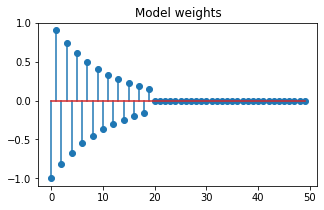

In [13]:
## Simulation setting
n_features = 50
nnz = 20
idx = np.arange(n_features)
w0 = (-1) ** (idx + 1) * np.exp(-idx / 10.)
w0[nnz:] = 0.

plt.figure(figsize=(5, 3))
plt.stem(w0)
plt.title("Model weights")

In [14]:
from scipy.optimize import check_grad

X, y = simu_linreg(w0, corr=0.6)
model = ModelLinReg(X, y, strength=1e-3)
w = np.random.randn(n_features)

send(float(check_grad(model.loss, model.grad, w)), 3)
print(check_grad(model.loss, model.grad, w)) # This must be a number (of order 1e-6)

2.264651653732849e-06


In [15]:
print("lip=", model.lip())
print("lip_max=", model.lip_max())
print("lip_coordinates=", model.lip_coordinates())

lip= 4.203283735208287
lip_max= 123.41220918733167
lip_coordinates= [0.99 0.96 1.02 0.99 1.05 1.06 1.   0.99 0.96 0.99 1.03 0.97 1.05 1.
 0.98 0.95 1.01 1.04 1.02 1.01 1.03 0.95 0.99 1.02 0.97 1.08 1.03 1.03
 0.98 0.98 0.95 0.95 0.99 0.99 0.99 1.06 1.   1.01 1.11 0.98 0.99 1.08
 1.06 1.08 1.05 0.99 1.   0.95 0.91 0.98]


In [19]:
model.hessian().shape

(50, 50)

<a id='models_logistic'></a>

## 2.3 Logistic regression

**NB**: you can skip these questions and go to the solvers implementation, and come back here later.

**1) Compute (on paper) the gradient $\nabla f$, the gradient of $\nabla f_i$ and the gradient of the coordinate function $\frac{\partial f(w)}{\partial w_j}$ of $f$ for logistic regression (fill the class given below).**

**2) Fill in the functions below for the computation of $f$, $\nabla f$, $\nabla f_i$ and $\frac{\partial f(w)}{\partial w_j}$ for logistic regression in the ModelLogReg class below.**

In [23]:
class ModelLogReg:
    """A class giving first order information for logistic regression
    
    Parameters
    ----------
    X : `numpy.array`, shape=(n_samples, n_features)
        The features matrix
    
    y : `numpy.array`, shape=(n_samples,)
        The vector of labels
    
    strength : `float`
        The strength of ridge penalization
    """    
    def __init__(self, X, y, strength):
        self.X = X
        self.y = y
        self.strength = strength
        self.n_samples, self.n_features = X.shape
    
    def loss(self, w):
        """Computes f(w)"""
        y, X, n_samples, strength = self.y, self.X, self.n_samples, self.strength
        ### TODO
        return np.mean(np.log(1+np.exp(- y * (X.dot(w))))) + strength * norm(w) ** 2 / 2
        ### END TODO
       
    def grad(self, w):
        """Computes the gradient of f at w"""
        y, X, n_samples, strength = self.y, self.X, self.n_samples, self.strength
        ### TODO
        u = y*np.exp(- y * (X.dot(w)))/(1 + np.exp(- y * (X.dot(w))))
        return - (X.T.dot(u))/n_samples + strength * w
       ### END TODO

    def grad_i(self, i, w):
        """Computes the gradient of f_i at w"""
        x_i = self.X[i]
        strength = self.strength
        ### TODO
        u = y[i]*np.exp(- y[i] * (x_i.dot(w)))/(1 + np.exp(- y[i] * (x_i.dot(w))))
        return (- u*x_i + strength * w)
        ### END TODO
    
    def grad_coordinate(self, j, w):
        """Computes the partial derivative of f with respect to 
        the j-th coordinate"""
        y, X, n_samples, strength = self.y, self.X, self.n_samples, self.strength
        ### TODO
        u = y*np.exp(- y * (X.dot(w)))/(1 + np.exp(- y * (X.dot(w))))
        return - (X[:, j].T.dot(u))/n_samples + strength * w[j]
        ### END TODO

    def lip(self):
        """Computes the Lipschitz constant of the gradient of  f"""
        X, n_samples = self.X, self.n_samples
        ### TODO
        return norm(X.T.dot(X), 2) / (4*n_samples) + self.strength
        ### END TODO

    def lip_coordinates(self):
        """Computes the Lipschitz constant of the gradient of f with respect to 
        the j-th coordinate"""
        X, n_samples = self.X, self.n_samples
        ### TODO
        return (X ** 2).sum(axis=0) / (4*n_samples) + self.strength
        ### END TODO

    def lip_max(self):
        """Computes the maximum of the lipschitz constants of the gradients of  f_i"""
        X, n_samples = self.X, self.n_samples
        ### TODO
        return ((X ** 2).sum(axis=1)/4 + self.strength).max()
        ### END TODO
     
    def hessian(self):
        X, n_samples = self.X, self.n_samples
        ### TODO
        return ((X ** 2).sum(axis=1)/4 + self.strength).max()
        ### END TODO
        
send(ModelLogReg.loss, 4)
send(ModelLogReg.grad, 5)
send(ModelLogReg.grad_i, 6)
send(ModelLogReg.grad_coordinate, 7)
send(ModelLogReg.lip, 8)
send(ModelLogReg.lip_coordinates, 9)
send(ModelLogReg.lip_max, 10)

<Response [200]>

<a id='models_logistic_check'></a>


## 2.4 Checks for the logistic regression model

**3) Use the function `simu_logreg` to simulate data according to the logistic regression model. Check numerically the gradient using the function ``checkgrad`` from ``scipy.optimize``, as we did for linear regression above.**

/Users/dieuleve/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  # This is added back by InteractiveShellApp.init_path()


Checkgrad returns 2.91e-07


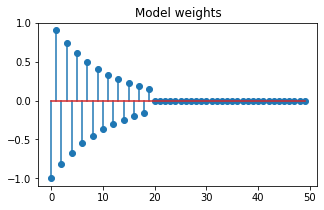

In [94]:


## Simulation setting
n_features = 50
nnz = 20
idx = np.arange(n_features)
w0 = (-1) ** (idx + 1) * np.exp(-idx / 10.)
w0[nnz:] = 0.

plt.figure(figsize=(5, 3))
plt.stem(w0)
plt.title("Model weights")

from scipy.optimize import check_grad



### TODO
X, y = simu_logreg(w0, corr=0.6)
model = ModelLogReg(X, y, strength=1e-6)
w = np.random.randn(n_features)
### END TODO
send('Checkgrad returns %.2e' % (check_grad(model.loss, model.grad, w)), 11)
print('Checkgrad returns %.2e' % (check_grad(model.loss, model.grad, w))) # This must be a number (of order 1e-6)


In [95]:
print("lip=", model.lip())
print("lip_max=", model.lip_max())
print("lip_coordinates=", model.lip_coordinates())

lip= 1.049638363565095
lip_max= 30.802507863255805
lip_coordinates= [0.23 0.25 0.25 0.25 0.24 0.25 0.25 0.26 0.24 0.23 0.24 0.25 0.25 0.25
 0.25 0.25 0.24 0.23 0.24 0.24 0.25 0.26 0.25 0.25 0.26 0.24 0.26 0.26
 0.24 0.25 0.26 0.26 0.25 0.25 0.25 0.27 0.25 0.23 0.25 0.24 0.23 0.24
 0.25 0.25 0.24 0.26 0.25 0.25 0.25 0.23]


<a id='solvers'></a>
## 3. Solvers

We now have classes `ModelLinReg` and `ModelLogReg` that allow to compute $f(w)$, $\nabla f(w)$, 
$\nabla f_i(w)$ and $\frac{\partial f(w)}{\partial w_j}$ for the objective $f$
given by linear and logistic regression. We want now to code and compare several solvers to minimize $f$.

<a id='tools'></a>
## 3.1. Tools for the solvers

The following tools store the loss after each epoch

In [96]:
# Starting point of all solvers
w0 = np.zeros(model.n_features)

# Number of iterations
n_iter = 50

# Random samples indices for the stochastic solvers (sgd, sag, svrg) 
idx_samples = np.random.randint(0, model.n_samples, model.n_samples * n_iter)

In [97]:
def inspector(model, n_iter, verbose=True):
    """A closure called to update metrics after each iteration.
    Don't even look at it, we'll just use it in the solvers."""
    objectives = []
    it = [0] # This is a hack to be able to modify 'it' inside the closure.
    def inspector_cl(w):
        obj = model.loss(w)
        objectives.append(obj)
        if verbose == True:
            if it[0] == 0:
                print(' | '.join([name.center(8) for name in ["it", "obj"]]))
            if it[0] % (n_iter / 5) == 0:
                print(' | '.join([("%d" % it[0]).rjust(8), ("%.6e" % obj).rjust(8)]))
            it[0] += 1
    inspector_cl.objectives = objectives
    return inspector_cl

<a id='gd'></a>
## 3.2 Gradient descent


**4) Finish the function `gd` below that implements the gradient descent algorithm and test it using the next cell.**

In [98]:
def gd(model, w0, n_iter, callback, verbose=True):
    """Gradient descent
    """
    step = 1 / model.lip()
    w = w0.copy()
    w_new = w0.copy()
    if verbose:
        print("Lauching GD solver...")
    callback(w)
    for k in range(n_iter + 1):
        ### TODO
        w_new[:] = w - step * model.grad(w)
        w[:] = w_new # Remark : does operation inplace
        ### END TODO
        callback(w)
    return w
send(gd, 12)

<Response [200]>

In [99]:
callback_gd = inspector(model, n_iter=n_iter)
w_gd = gd(model, w0, n_iter=n_iter, callback=callback_gd)

Lauching GD solver...
   it    |   obj   
       0 | 6.931472e-01
      10 | 5.944509e-01
      20 | 5.726391e-01
      30 | 5.641559e-01
      40 | 5.603721e-01
      50 | 5.585550e-01


<a id='agd'></a>
## 3.3 Accelerated gradient descent

**5) Finish the function `agd` below that implements the accelerated gradient descent algorithm and test it using the next cell.**

In [100]:
def agd(model, w0, n_iter, callback, verbose=True):
    """Accelerated gradient descent
    """
    step = 1 / model.lip()
    w = w0.copy()
    w_new = w0.copy()
    # An extra variable is required for acceleration
    z = w0.copy() # the auxiliari point at which the gradient is taken
    t = 1. # beta this morning = momentum coefficient 
    t_new = 1.    
    if verbose:
        print("Lauching AGD solver...")
    callback(w)
    for k in range(n_iter + 1):
        ### TODO
        w_new[:] = z - step * model.grad(z)
        
        # Trivial choice
        # t_new = 0.9
        
        t_new = (1. + (1. + 4. * t * t) ** (0.5)) / 2. # Optimal momentum coefficinet for smooth convex
        beta = (t - 1) / t_new
        # see https://blogs.princeton.edu/imabandit/2018/11/21/a-short-proof-for-nesterovs-momentum/
        # Simpler choice:
        beta = k/(k+3)
        
        # t_new = k/k+3 (other solution in convex)
        # kappa = model.lip()/model.strenth() 
        # beta = (1-(1/kappa)**0.5 )/(1+(1/kappa)**0.5) # For strongly convex
        # see https://blogs.princeton.edu/imabandit/2014/03/06/nesterovs-accelerated-gradient-descent-for-smooth-and-strongly-convex-optimization/
        
        z[:] = w_new + beta * (w_new - w)
        t = t_new
        w[:] = w_new
        ### END TODO        
        callback(w)
    return w

send(agd, 13)

<Response [200]>

In [101]:
callback_agd = inspector(model, n_iter=n_iter)
w_agd = agd(model, w0, n_iter=n_iter, callback=callback_agd)

Lauching AGD solver...
   it    |   obj   
       0 | 6.931472e-01
      10 | 5.712684e-01
      20 | 5.566597e-01
      30 | 5.569070e-01
      40 | 5.566269e-01
      50 | 5.566541e-01


<a id='cgd'></a>

## 3.4 Coordinate gradient descent

**6) Finish the function `cgd` below that implements the coordinate gradient descent algorithm and test it using the next cell.**

In [102]:
def cgd(model, w0, n_iter, callback, verbose=True):
    """Coordinate gradient descent
    """
    w = w0.copy()
    n_features = model.n_features
    steps = 1 / model.lip_coordinates()
    if verbose:
        print("Lauching CGD solver...")
    callback(w)
    for k in range(n_iter + 1):
        ### TODO
        for j in range(n_features): # 50 features
            w[j] -= steps[j] * model.grad_coordinate(j, w)  # 
        ### END TODO
        callback(w)
    return w
send(cgd, 14)

<Response [200]>

In [103]:
callback_cgd = inspector(model, n_iter=n_iter)
w_cgd = cgd(model, w0, n_iter=n_iter, callback=callback_cgd)

Lauching CGD solver...
   it    |   obj   
       0 | 6.931472e-01
      10 | 5.570530e-01
      20 | 5.566291e-01
      30 | 5.566221e-01
      40 | 5.566220e-01
      50 | 5.566220e-01


<a id='sgd'></a>
## 3.5. Stochastic gradient descent

**7) Finish the function `sgd` below that implements the st stochastic gradient descent algorithm and test it using the next cell.**

In [104]:
def sgd(model, w0, idx_samples, n_iter, step, callback, verbose=True):
    """Stochastic gradient descent
    """
    w = w0.copy()
    w_ave = w0.copy()
    callback(w)
    n_samples = model.n_samples
    for idx in range(n_iter):
        i = idx_samples[idx]
        ### TODO
        w -= step * model.grad_i(i, w)/ (np.sqrt(idx + 1)) # decays at 1/sqrt{k} good choice for convex functions
        # decent choice for strongly convex
        # also possible to use 1/ (model.strength() * k) (choice in the slides)
        
        # w_ave =  idx/(idx+1)*w_ave + 1/(idx+1)*w
        
        ## IMPLEMENT PR AVERAGE 
        
        ### END TODO  # every n_samples iterations 
        if idx % n_samples == 0:
            callback(w) #w_ave
    return w
send(sgd, 15)

<Response [200]>

In [105]:
step = 1e-1
callback_sgd = inspector(model, n_iter=n_iter)
w_sgd = sgd(model, w0, idx_samples, n_iter=model.n_samples * n_iter, 
            step=step, callback=callback_sgd)

   it    |   obj   
       0 | 6.931472e-01
      10 | 5.925675e-01
      20 | 5.782849e-01
      30 | 5.720361e-01
      40 | 5.684581e-01
      50 | 5.662035e-01


In [106]:
callback_sgd.objectives[0:5], callback_agd.objectives[0:5],  callback_gd.objectives[0:5]  # in terms of passes

([0.6931471805599454,
  0.7440804255231553,
  0.660109784622778,
  0.6350192695629714,
  0.6224656806857957],
 [0.6931471805599454,
  0.6649261240788282,
  0.648879052872999,
  0.6342913628014946,
  0.6211089038098663],
 [0.6931471805599454,
  0.6649261240788282,
  0.648879052872999,
  0.6370318314674263,
  0.627593607603908])

<a id='sag'></a>
## 3.6. Stochastic average gradient descent


**8) Finish the function `sag` below that implements the stochastic averaged gradient algorithm and test it using the next cell.**

In [107]:
def sag(model, w0, idx_samples, n_iter, step, callback, verbose=True):
    """Stochastic average gradient descent
    """
    w = w0.copy()
    n_samples, n_features = model.n_samples, model.n_features
    gradient_memory = np.zeros((n_samples, n_features)) # one gradient per sample n= 60k,  d= 50M  => 3 10^12
    y = np.zeros(n_features)
    callback(w)
    for idx in range(n_iter):
        i = idx_samples[idx]        
        ### TODO
        y_new = model.grad_i(i, w)
        y += (y_new - gradient_memory[i]) / n_samples
        gradient_memory[i] = y_new
        w -= step * y
        ### END TODO        
        if idx % n_samples == 0:
            callback(w)
    return w
send(sag, 16)

<Response [200]>

In [108]:
step = 1 / model.lip_max()
callback_sag = inspector(model, n_iter=n_iter)
w_sag = sag(model, w0, idx_samples, n_iter=model.n_samples * n_iter, 
            step=step, callback=callback_sag)

   it    |   obj   
       0 | 6.931472e-01
      10 | 5.574429e-01
      20 | 5.566307e-01
      30 | 5.566220e-01
      40 | 5.566220e-01
      50 | 5.566220e-01


<a id='svrg'></a>
## 3.7. Stochastic variance reduced gradient

**9) Finish the function `svrg` below that implements the stochastic variance reduced gradient algorithm and test it using the next cell.**

In [109]:
def svrg(model, w0, idx_samples, n_iter, step, callback, verbose=True):
    """Stochastic variance reduced gradient descent
    """
    w = w0.copy()
    w_old = w.copy()
    temp_sum = 0
    n_samples = model.n_samples
    callback(w)
    for idx in range(n_iter):        
        ### TODO
        if idx % n_samples == 0:
            w_old[:] = temp_sum/n_samples
            mu = model.grad(w)
            temp_sum = 0
        i = idx_samples[idx]
        z_new = model.grad_i(i, w)
        z_old = model.grad_i(i, w_old)  ### w_old is the only thinng I keep, I can recompute the gradient f_i (w_old)
        ## SVRG trades memory for computation
        w -= step * (z_new - z_old + mu)
        temp_sum += w
        ### END TODO        
        if idx % n_samples == 0:
            callback(w)
    return 
send(svrg, 17)

<Response [200]>

In [110]:
step = 1 / model.lip_max()
callback_svrg = inspector(model, n_iter=n_iter)
w_svrg = svrg(model, w0, idx_samples, n_iter=model.n_samples * n_iter,
              step=step, callback=callback_svrg)

   it    |   obj   
       0 | 6.931472e-01
      10 | 5.572397e-01
      20 | 5.566227e-01
      30 | 5.566220e-01
      40 | 5.566220e-01
      50 | 5.566220e-01


<a id='adagrad'></a>

## 3.8 ADAGRAD

**10) Create the function `adagrad` that implements the adagrad solver and test it.**

In [111]:
##################


def adagrad(model, w0, n_iter, step, callback, verbose=True):
    """Adagrad"""
### TODO
    w = w0.copy()
    n_features = model.n_features
    sum_gradient_square = np.zeros(n_features)
    if verbose:
        print("Lauching Adagrad solver...")
    callback(w)
    for k in range(n_iter + 1):
        gradient = model.grad(w)
        sum_gradient_square += gradient**2
        w -= (step/(np.sqrt(sum_gradient_square)))*gradient
        callback(w)
    return w

### END TODO
##################
send(adagrad, 18)

<Response [200]>

In [112]:
##################
### TODO

step = 0.01
callback_adagrad = inspector(model, n_iter=n_iter)
w_adagrad = adagrad(model, w0, n_iter=n_iter,
              step=step, callback=callback_adagrad)

### END TODO
##################

Lauching Adagrad solver...
   it    |   obj   
       0 | 6.931472e-01
      10 | 6.640045e-01
      20 | 6.536899e-01
      30 | 6.466657e-01
      40 | 6.412458e-01
      50 | 6.368084e-01


<a id='rmsprop'></a>


## 3.9 RMSProp

**11) Create the function `rmsprop` that implements the RMSProp solver and test it.**

In [43]:


def rmsprop(model, w0, n_iter, step, rho, epsilon, callback, verbose=True):
##################
### TODO
    """RMSProp"""
    w = w0.copy()
    n_features = model.n_features
    accumulated_square_gradient = np.zeros(n_features)
    if verbose:
        print("Lauching RMSProp solver...")
    callback(w)
    for k in range(n_iter + 1):
        gradient = model.grad(w)
        accumulated_square_gradient = rho*accumulated_square_gradient + (1-rho) *(gradient)**2
        w -= (step/(np.sqrt(accumulated_square_gradient + epsilon)))*gradient  
        callback(w)
    return w

### END TODO
##################
send(rmsprop, 19)

<Response [200]>

In [44]:
##################
### TODO

step = 0.001
rho = 0.9
epsilon = 0.000001
callback_rmsprop = inspector(model, n_iter=n_iter)
w_rmsprop = rmsprop(model, w0, n_iter=n_iter, step = step,
              rho = rho, epsilon = epsilon, callback=callback_rmsprop)

### END TODO
##################

Lauching RMSProp solver...
   it    |   obj   
       0 | 6.93e-01
      10 | 6.79e-01
      20 | 6.71e-01
      30 | 6.66e-01
      40 | 6.60e-01
      50 | 6.55e-01


<a id='adadelta'></a>

## 3.10 AdaDelta

**12) Create the function `adadelta` that implements adadelta solver and test it.**

In [45]:


def adadelta(model, w0, n_iter, rho, epsilon, callback, verbose=True):
##################
### TODO
    """Adadelta"""
    w = w0.copy()
    w_old = w0.copy()
    n_features = model.n_features
    accumulated_square_gradient = np.zeros(n_features)
    accumulated_square_weights = np.zeros(n_features)
    if verbose:
        print("Lauching Adadelta solver...")
    callback(w)
    for k in range(n_iter + 1):
        gradient = model.grad(w)
        accumulated_square_gradient = rho*accumulated_square_gradient + (1-rho) *(gradient)**2
        w_old[:] = w[:]
        w -= ((np.sqrt(accumulated_square_weights + epsilon))/(np.sqrt(accumulated_square_gradient + epsilon)))*(gradient)    
        accumulated_square_weights = rho*accumulated_square_weights + (1-rho) *(w - w_old)**2
        callback(w)
    return w

### END TODO
##################
send(adadelta, 20)

<Response [200]>

In [46]:
##################
### TODO

rho = 0.95
epsilon = 0.000001
callback_adadelta = inspector(model, n_iter=n_iter)
w_adadelta = adadelta(model, w0, n_iter=n_iter,
              rho = rho, epsilon = epsilon, callback=callback_adadelta)

### END TODO
##################

Lauching Adadelta solver...
   it    |   obj   
       0 | 6.93e-01
      10 | 6.64e-01
      20 | 6.45e-01
      30 | 6.31e-01
      40 | 6.19e-01
      50 | 6.09e-01


<a id='adam'></a>


## 3.11 Adam

**13) Create the function `adam` that implements the adam algorithm and test it.**

In [47]:


def adam(model, w0, n_iter, step, beta1, beta2, epsilon, callback, verbose=True):
##################
### TODO
    "Adam"
    w = w0.copy()
    n_features = model.n_features
    accumulated_gradient = np.zeros(n_features)
    accumulated_square_gradient = np.zeros(n_features)
    if verbose:
        print("Lauching Adam solver...")
    callback(w)
    for k in range(n_iter + 1):
        gradient = model.grad(w)
        accumulated_gradient = beta1*accumulated_gradient + (1-beta1)*gradient
        accumulated_gradient_correction = accumulated_gradient/(1 - beta1**(k+1))
        accumulated_square_gradient = beta2*accumulated_square_gradient + (1-beta2) *(gradient)**2
        accumulated_square_gradient_correction = accumulated_square_gradient/(1 - beta2**(k+1))
        w -= - (step /(np.sqrt(accumulated_square_gradient_correction) + epsilon))*accumulated_gradient_correction
        callback(w)
    return w

### END TODO
##################
send(adam, 21)

<Response [200]>

In [48]:
##################
### TODO

step = 0.001
beta1 = 0.9
beta2 = 0.999
epsilon = 10**(-6)

callback_adam = inspector(model, n_iter=n_iter)
w_adam = adam(model, w0, n_iter=n_iter, step = step, beta1 = beta1, beta2 = beta2, 
              epsilon = epsilon, callback=callback_adam)
              
### END TODO
##################

Lauching Adam solver...
   it    |   obj   
       0 | 6.93e-01
      10 | 7.05e-01
      20 | 7.21e-01
      30 | 7.40e-01
      40 | 7.65e-01
      50 | 7.95e-01


<a id='adamax'></a>


## 3.12 Adamax

**14) Create the function `adamax` that implements the adamax solver and test it.**

In [49]:
##################
### TODO

def adamax(model, w0, n_iter, step, beta1, beta2, callback, verbose=True):
    """Adamax"""
    w = w0.copy()
    n_features = model.n_features
    accumulated_gradient = np.zeros(n_features)
    u =  np.zeros(n_features)
    if verbose:
        print("Lauching Adamax solver...")
    callback(w)
    for k in range(n_iter + 1):
        gradient = model.grad(w)
        accumulated_gradient = beta1*accumulated_gradient + (1-beta1)*gradient
        accumulated_gradient_correction = accumulated_gradient/(1 - beta1**(k+1))
        u = np.maximum(beta2*u, abs(gradient))
        w  -= - (step /u)*accumulated_gradient_correction
        callback(w)
    return w

### END TODO
##################
send(adamax, 22)

<Response [200]>

In [50]:
##################
### TODO

step = 0.001
beta1 = 0.9
beta2 = 0.999
epsilon = 10**(-6)
callback_adamax = inspector(model, n_iter=n_iter)
w_adamax = adamax(model, w0, n_iter=n_iter, step = step,
              beta1 = beta1, beta2 = beta2, callback=callback_adamax)

### END TODO
##################

Lauching Adamax solver...
   it    |   obj   
       0 | 6.93e-01
      10 | 7.04e-01
      20 | 7.17e-01
      30 | 7.32e-01
      40 | 7.49e-01
      50 | 7.68e-01


<a id='comparison'></a>
# 4. Comparison of all algorithms

**15) Plot the values of the loss for the different iteration and for each solver. Comment. **

In [113]:
callbacks = [callback_gd, callback_agd, callback_cgd, callback_sgd, 
             callback_sag, callback_svrg]
#callback_adagrad, callback_rmsprop, callback_adadelta, callback_adam, callback_adamax]
names = ["GD", "AGD", "CGD", "SGD", "SAG", "SVRG"]
#"ADAGRAD", "RMSPROP", "ADADELTA",        "ADAM", "ADAMAX"]

callback_long = inspector(model, n_iter=1000, verbose=False)
w_cgd = cgd(model, w0, n_iter=1000, callback=callback_long, verbose=False)
obj_min = callback_long.objectives[-1]

<Response [200]>

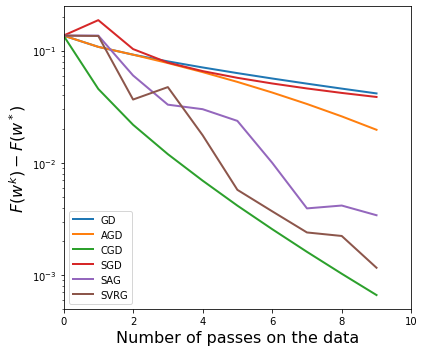

In [115]:
plt.figure(figsize=(6, 5))
plt.yscale("log")

for callback, name in zip(callbacks, names):
    objectives = np.array(callback.objectives[0:10])
    objectives_dist = objectives - obj_min    
    plt.plot(objectives_dist, label=name, lw=2)

plt.tight_layout()
plt.xlim((0, n_iter/5))
plt.xlabel("Number of passes on the data", fontsize=16)
plt.ylabel(r"$F(w^k) - F(w^*)$", fontsize=16)
plt.legend(loc='lower left')
plt.tight_layout()
send(plt, 23)

**16) In logistic regression, study the influence of the correlation of the features on the performance of the optimization algorithms. Explain.**

**17) In logistic regression, study the influence of the level of ridge penalization on the performance of the optimization algorithms. Explain.**

**18) (OPTIONAL) All algorithms can be modified to handle an objective of the form $f + g$ with $g$ separable and prox-capable. Modify all the algorithms and try them out for L1 penalization $f(w) = \lambda \sum_{j=1}^d |w_j|$**